## load google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/GL-GenAI/Week17-Evaluation-Ragas_DeepEval")
os.listdir()

['SM-Evaluating_Agents_with_Ragas.ipynb',
 'Evaluating_Agents_with_Ragas.ipynb',
 'config1_api.json']

In [ ]:
%%writefile config1_api.json
{
"AZURE_OPENAI_KEY": "",
"AZURE_OPENAI_ENDPOINT": "",
"AZURE_OPENAI_APITYPE": "azure",
"CHATGPT_MODEL": "gpt-4o-mini",
"ALPHA_API_KEY": "",
"AZURE_OPENAI_APIVERSION": "",

"GROQ_API_KEY": "",
"hf_token": "",
"LLAMA_KEY": "",
"mem0_api": "",
"WANDB_API_KEY": ""

}

Overwriting config1_api.json


In [ ]:
import json

In [ ]:
# Define a function to read a JSON config file and return its contents as a dictionary.
def read_config(config_file):
  """Reads a JSON config file and returns a dictionary."""
  with open(config_file, 'r') as f:
    return json.load(f)


In [ ]:
config = read_config("config1_api.json")  #Copy and paste the path of the config file uploaded in Colab
api_key = config.get("AZURE_OPENAI_KEY")
AZURE_OPENAI_ENDPOINT = config.get("AZURE_OPENAI_ENDPOINT")
api_type = config.get("AZURE_OPENAI_APITYPE")
AZURE_OPENAI_KEY = config.get("AZURE_OPENAI_KEY")
AZURE_OPENAI_APIVERSION = config.get("AZURE_OPENAI_APIVERSION")
CHATGPT_MODEL = config.get("CHATGPT_MODEL")

# Using Ragas to Evaluate an Agent Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

We'll:

- Collect our data
- Create a simple Agent application
- Evaluate our Agent application

> NOTE: This notebook is modified from Ragas' Official Documentation [LangGraph tutorial](https://docs.ragas.io/en/stable/howtos/integrations/_langgraph_agent_evaluation/)!

## Installing Ragas and Other Dependencies
Install Ragas and Langgraph with pip:

In [ ]:
# !pip install -qU langgraph==0.2.44 ragas==0.2.12 nltk

In [ ]:
!pip install -U fsspec
!pip install langgraph ragas nltk # Try again after updating fsspec

  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [ ]:
import langgraph
try:
    from langgraph import version
    print(f"Version from version module: {version.__version__}")
except (ImportError, AttributeError):
    print("Could not import version from langgraph")

Version from version module: 0.3.31


In [ ]:
!pip install -qU langgraph-prebuilt

In [ ]:
from langchain_core.tools import tool
from langchain.agents import create_react_agent
from langchain.agents import AgentExecutor

In [ ]:
!pip list | grep langgraph

langgraph                             0.3.31
langgraph-checkpoint                  2.0.24
langgraph-prebuilt                    0.1.8
langgraph-sdk                         0.1.63


### Alpha Vantage API Key

Get free api key from https://www.alphavantage.co/support/#api-key

In [ ]:
# import os
# import getpass

# os.environ["ALPHA_API_KEY"] = getpass.getpass("Enter your API key: ")

## Building the ReAct Agent

### Define the get_stock_price Tool

The get_stock_price tool will be used by the agent to fetch the stock price of a specified company. We'll create this tool using the @tool decorator from LangChain.

In [ ]:
from langchain_core.tools import tool
import requests
import pandas as pd


@tool
def get_stock_price(ticker: str):
    """
    Fetches the stock price for a given ticker symbol using the Alpha Vantage API.

    Args:
        ticker (str): The ticker symbol of the stock.

    Returns:
        pd.DataFrame: A dataframe containing the latest stock data with 30min interval.
    """
    # Define your Alpha Vantage API key
    alpha_api_key = os.environ.get("ALPHA_API_KEY")

    # Construct the API request URL
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={ticker}&interval=30min&outputsize=full&apikey={alpha_api_key}'
    response = requests.get(url)
    data = response.json()

    # Check if the response contains the 'Time Series (30min)' key
    if 'Time Series (30min)' not in data:
        return f"Error: {data.get('Note', 'Unable to fetch data.')}"

    # Extract the time series data
    time_series = data['Time Series (30min)']

    # Convert the time series data into a DataFrame
    df = pd.DataFrame.from_dict(time_series, orient='index')

    # Rename the columns
    df.columns = ['open', 'high', 'low', 'close', 'volume']

    # Convert the index to datetime format
    df.index = pd.to_datetime(df.index)

    # Filter for the latest date
    latest_date = df.index.max().date()
    filtered_df = df[df.index.date == latest_date]

    return filtered_df



@tool
def calculate_percentage(stock_price: float, percentage: float) -> float:
    """
    Calculates the specified percentage of the given stock price.

    Args:
        stock_price (float): The current stock price.
        percentage (float): The percentage to calculate.

    Returns:
        float: The calculated percentage value of the stock price.
    """
    calculated_value = (percentage / 100) * stock_price
    return calculated_value

## trying the stock price tool

In [ ]:
get_stock_price.invoke("AAPL")


,open,high,low,close,volume
2025-04-21 19:30:00,192.6900,194.0000,192.6100,194.0000,49735
2025-04-21 19:00:00,192.7500,192.8900,192.5600,192.7000,9030
2025-04-21 18:30:00,192.5200,193.1600,192.5200,192.8200,10958
2025-04-21 18:00:00,192.9700,230.1900,192.3000,192.5257,14864
2025-04-21 17:30:00,192.8200,192.9900,192.7000,192.8800,5636
2025-04-21 17:00:00,193.0800,202.4032,186.2630,192.7300,24167
2025-04-21 16:30:00,192.7000,201.7418,180.6242,193.0800,763612
2025-04-21 16:00:00,193.2100,193.4000,179.7725,192.6500,20125717
2025-04-21 15:30:00,191.0900,193.4300,191.0500,193.0900,5337997
2025-04-21 15:00:00,190.2700,191.3800,190.2400,191.1050,1904167


In [ ]:
calculate_percentage.invoke(input={"stock_price": "100.00", "percentage": "25.0"})

25.0

### Binding the Tool to the LLM
With the get_stock_price tool defined, the next step is to bind it to the AzureChatOpenAI model. This enables the agent to invoke the tool during its execution based on the user's requests allowing it to interact with external data and perform actions beyond its native capabilities.

In [ ]:
# import json

# with open ('config1_api.json') as f:
#     cred1 = json.load(f)

In [ ]:
from langchain_openai import ChatOpenAI

In [ ]:
# Initialize the Chat OpenAI model
llm = ChatOpenAI(
    openai_api_base=AZURE_OPENAI_ENDPOINT,  # Fill in the endpoint
    openai_api_key=api_key,  # Fill in the API key
    model="gpt-4o-mini",  # Fill in the deployment name (e.g., gpt-4o-mini)
    streaming=False
)

tools = [get_stock_price, calculate_percentage]
llm_with_tools = llm.bind_tools(tools)

In LangGraph, state plays a crucial role in tracking and updating information as the graph executes. As different parts of the graph run, the state evolves to reflect the changes and contains information that is passed between nodes.

For example, in a conversational system like this one, the state is used to track the exchanged messages. Each time a new message is generated, it is added to the state and the updated state is passed through the nodes, ensuring the conversation progresses logically.

### Defining the State
To implement this in LangGraph, we define a state class that maintains a list of messages. Whenever a new message is produced it gets appended to this list, ensuring that the conversation history is continuously updated.

In [ ]:
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Defining the should_continue Function
The `should_continue` function determines whether the conversation should proceed with further tool interactions or end. Specifically, it checks if the last message contains any tool calls (e.g., a request for stock prices).

- If the last message includes tool calls, indicating that the agent has invoked an external tool, the conversation continues and moves to the "tools" node.
- If there are no tool calls, the conversation ends, represented by the END state.

In [ ]:
# Define the function that determines whether to continue or not
def should_continue(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

### Calling the Model
The `call_model` function interacts with the Language Model (LLM) to generate a response based on the current state of the conversation. It takes the updated state as input, processes it and returns a model-generated response.

In [ ]:
# Define the function that calls the model
def call_model(state: GraphState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

### Creating the Assistant Node
The `assistant` node is a key component responsible for processing the current state of the conversation and using the Language Model (LLM) to generate a relevant response. It evaluates the state, determines the appropriate course of action, and invokes the LLM to produce a response that aligns with the ongoing dialogue.

In [ ]:
# Node
def assistant(state: GraphState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

### Creating the Tool Node
The `tool_node` is responsible for managing interactions with external tools, such as fetching stock prices or performing other actions beyond the LLM's native capabilities. The tools themselves are defined earlier in the code, and the tool_node invokes these tools based on the current state and the needs of the conversation.

In [ ]:
from langgraph.prebuilt import ToolNode

# Node
tools = [get_stock_price, calculate_percentage]
tool_node = ToolNode(tools)

### Building the Graph
The graph structure is the backbone of the agentic workflow, consisting of interconnected nodes and edges. To construct this graph, we use the StateGraph builder which allows us to define and connect various nodes. Each node represents a step in the process (e.g., the assistant node, tool node) and the edges dictate the flow of execution between these steps.

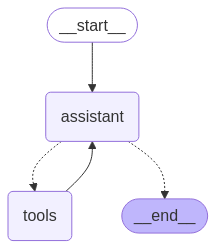

In [ ]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Define a new graph for the agent
builder = StateGraph(GraphState)

# Define the two nodes we will cycle between
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)

# Set the entrypoint as `agent`
builder.add_edge(START, "assistant")

# Making a conditional edge
# should_continue will determine which node is called next.
builder.add_conditional_edges("assistant", should_continue, ["tools", END])

# Making a normal edge from `tools` to `agent`.
# The `agent` node will be called after the `tool`.
builder.add_edge("tools", "assistant")

# Compile and display the graph for a visual overview
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

To test our setup, we will run the agent with a query. The agent will fetch the stock price of Apple company using the Alpha API key.

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    HumanMessage(
        content="What is the current stock price of Apple?"
    )
]

result = react_graph.invoke({"messages": messages})

In [ ]:
result["messages"]

[HumanMessage(content='What is the current stock price of Apple?', additional_kwargs={}, response_metadata={}, id='0e3a2a0a-f862-4ea5-ba99-48dafc8b544a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8VLjpasJSLCI5748Oi2XrDXe', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 159, 'total_tokens': 176, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BP9YaYze04Jt3m7kbZ9yVp28Gmeb7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-82968e89-6b05-4b09-9a16-0c883293732c-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'AAPL'}, 'id': 'call_8VLjpasJSLCI5748Oi

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    HumanMessage(
        content="Can you tell me what is 25 percent of current stock price of Apple?"
    )
]

result = react_graph.invoke({"messages": messages})

In [ ]:
result["messages"]

[HumanMessage(content='Can you tell me what is 25 percent of current stock price of Apple?', additional_kwargs={}, response_metadata={}, id='52be231e-83e7-4450-b782-88d57758500a'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4vdXb9TKQRLttruIqNRYgCJW', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 166, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BP9nFEf6sBUNSlhkyCV4By4dhCmpS', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-17d633ea-5616-4e92-93d2-fe7c491a1080-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'AAPL'}, 'id'

### Converting Messages to Ragas Evaluation Format

In the current implementation, the GraphState stores messages exchanged between the human user, the AI (LLM's responses), and any external tools (APIs or services the AI uses) in a list. Each message is an object in LangChain's format

```python
# Implementation of Graph State
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
```

Each time a message is exchanged during agent execution, it gets added to the messages list in the GraphState. However, Ragas requires a specific message format for evaluating interactions.

Ragas uses its own format to evaluate agent interactions. So, if you're using LangGraph, you will need to convert the LangChain message objects into Ragas message objects. This allows you to evaluate your AI agents with Ragas’ built-in evaluation tools.

**Goal:**  Convert the list of LangChain messages (e.g., HumanMessage, AIMessage, and ToolMessage) into the format expected by Ragas, so the evaluation framework can understand and process them properly.

To convert a list of LangChain messages into a format suitable for Ragas evaluation, Ragas provides the function [convert_to_ragas_messages][ragas.integrations.langgraph.convert_to_ragas_messages], which can be used to transform LangChain messages into the format expected by Ragas.

Here's how you can use the function:

In [ ]:
from ragas.integrations.langgraph import convert_to_ragas_messages

# Assuming 'result["messages"]' contains the list of LangChain messages
ragas_trace = convert_to_ragas_messages(result["messages"])

In [ ]:
ragas_trace  # List of Ragas messages

[HumanMessage(content='Can you tell me what is 25 percent of current stock price of Apple?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_stock_price', args={'ticker': 'AAPL'})]),
 ToolMessage(content='                         open      high       low     close    volume\n2025-04-21 19:30:00  192.6900  194.0000  192.6100  194.0000     49735\n2025-04-21 19:00:00  192.7500  192.8900  192.5600  192.7000      9030\n2025-04-21 18:30:00  192.5200  193.1600  192.5200  192.8200     10958\n2025-04-21 18:00:00  192.9700  230.1900  192.3000  192.5257     14864\n2025-04-21 17:30:00  192.8200  192.9900  192.7000  192.8800      5636\n2025-04-21 17:00:00  193.0800  202.4032  186.2630  192.7300     24167\n2025-04-21 16:30:00  192.7000  201.7418  180.6242  193.0800    763612\n2025-04-21 16:00:00  193.2100  193.4000  179.7725  192.6500  20125717\n2025-04-21 15:30:00  191.0900  193.4300  191.0500  193.0900   5337997\n2025-04-21 15:00:00  19

## Evaluating the Agent's Performance

For this tutorial, let us evaluate the Agent with the following metrics:

- [Tool call Accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#tool-call-accuracy):ToolCallAccuracy is a metric that can be used to evaluate the performance of the LLM in identifying and calling the required tools to complete a given task.  

- [Agent Goal accuracy](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/#agent-goal-accuracy): Agent goal accuracy is a metric that can be used to evaluate the performance of the LLM in identifying and achieving the goals of the user. This is a binary metric, with 1 indicating that the AI has achieved the goal and 0 indicating that the AI has not achieved the goal.
- [Topic Adherence](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/agents/): Topic adherence is a metric that can be used to ensure the Agent system is staying "on-topic", meaning that it's not straying from the intended use case. You can think of this as a kinda of faithfulness, where the responses of the LLM should stay faithful to the topic provided.


First, let us actually run our Agent with a couple of queries, and make sure we have the ground truth labels for these queries.

### Tool Call Accuracy

In [ ]:
from ragas.metrics import ToolCallAccuracy
from ragas.dataset_schema import MultiTurnSample
from ragas.integrations.langgraph import convert_to_ragas_messages
import ragas.messages as r


ragas_trace = convert_to_ragas_messages(
    messages=result["messages"]
)  # List of Ragas messages converted using the Ragas function

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_tool_calls=[
        r.ToolCall(name="get_stock_price", args={"ticker": "AAPL"}),
        r.ToolCall(name="calculate_percentage", args={"percentage": "25"})
    ],
)

tool_accuracy_scorer = ToolCallAccuracy()
tool_accuracy_scorer.llm = llm
await tool_accuracy_scorer.multi_turn_ascore(sample)

1.0

Tool Call Accuracy: 1, because the LLM correctly identified and used the necessary tool (get_stock_price) with the correct parameters (i.e., ticker as "AAPL").

### Agent Goal Accuracy

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(
        content="You are a stock price assistant. Fetch the company ticker and get stock details for the user."
    ),
    HumanMessage(
        content="What is the current stock price of Nvidia?"
    )
]

result = react_graph.invoke({"messages": messages})

In [ ]:
result["messages"]  # List of Langchain messages

[SystemMessage(content='You are a stock price assistant. Fetch the company ticker and get stock details for the user.', additional_kwargs={}, response_metadata={}, id='43bbe55b-1f41-4b2f-a8b8-95c368e8b06a'),
 HumanMessage(content='What is the current stock price of Nvidia?', additional_kwargs={}, response_metadata={}, id='52272421-de77-4a60-b29c-138730f906ab'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3uCG84UfTSZr46tZyCtPGrt3', 'function': {'arguments': '{"ticker":"NVDA"}', 'name': 'get_stock_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 178, 'total_tokens': 195, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BP9ZT0xMZZEc2KvVjYQB

In [ ]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='What is the current stock price of Nvidia?', metadata=None, type='human'),
 AIMessage(content='', metadata=None, type='ai', tool_calls=[ToolCall(name='get_stock_price', args={'ticker': 'NVDA'})]),
 ToolMessage(content='                        open      high      low    close    volume\n2025-04-21 19:30:00  96.0300   96.6500  96.0110  96.6500    473582\n2025-04-21 19:00:00  96.0500   96.1500  95.9900  96.0400    183861\n2025-04-21 18:30:00  96.0495   96.9100  95.9800  96.0490    306603\n2025-04-21 18:00:00  96.3400  108.6550  95.9000  96.0500    468974\n2025-04-21 17:30:00  96.2795   96.9100  96.2500  96.3400   1669999\n2025-04-21 17:00:00  96.2301  103.0794  89.6371  96.2600    359567\n2025-04-21 16:30:00  96.6800  102.6930  90.3748  96.2399  10981234\n2025-04-21 16:00:00  96.8000  100.1550  95.5250  96.6800  58801020\n2025-04-21 15:30:00  95.6000   97.2000  95.6000  96.8000  28825311\n2025-04-21 15:00:00  95.2950   99.1126  95.2050  95.6000  13929363\n2025-04-21

In [ ]:
from ragas.dataset_schema import MultiTurnSample
from ragas.metrics import AgentGoalAccuracyWithReference
from ragas.llms import LangchainLLMWrapper


sample = MultiTurnSample(
    user_input=ragas_trace,
    reference="current stock price of Nvidia",
)

scorer = AgentGoalAccuracyWithReference()

evaluator_llm = LangchainLLMWrapper(llm)
scorer.llm = evaluator_llm
await scorer.multi_turn_ascore(sample)

1.0

Agent Goal Accuracy: 1, because the LLM correctly achieved the user’s goal of retrieving the stock price of Nvidia Company.

### Topic Adherence



In [ ]:
messages = [HumanMessage(content="How fast can an eagle fly?")]

result = react_graph.invoke({"messages": messages})

In [ ]:
result["messages"]

[HumanMessage(content='How fast can an eagle fly?', additional_kwargs={}, response_metadata={}, id='615c0483-fc83-49c5-880b-e35fc788dcca'),
 AIMessage(content='Eagles are known for their impressive flying abilities. The speed of an eagle can vary depending on the species and the circumstances. Generally, eagles can fly at speeds ranging from 30 to 50 miles per hour (48 to 80 kilometers per hour) during level flight. However, when diving to catch prey, some eagles can reach speeds of over 100 miles per hour (160 kilometers per hour). The golden eagle, for example, is known for its remarkable diving speed.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 157, 'total_tokens': 257, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18',

In [ ]:
from ragas.integrations.langgraph import convert_to_ragas_messages

ragas_trace = convert_to_ragas_messages(
    result["messages"]
)  # List of Ragas messages converted using the Ragas function
ragas_trace

[HumanMessage(content='How fast can an eagle fly?', metadata=None, type='human'),
 AIMessage(content='Eagles are known for their impressive flying abilities. The speed of an eagle can vary depending on the species and the circumstances. Generally, eagles can fly at speeds ranging from 30 to 50 miles per hour (48 to 80 kilometers per hour) during level flight. However, when diving to catch prey, some eagles can reach speeds of over 100 miles per hour (160 kilometers per hour). The golden eagle, for example, is known for its remarkable diving speed.', metadata=None, type='ai', tool_calls=[])]

In [ ]:
from ragas.metrics import TopicAdherenceScore

sample = MultiTurnSample(
    user_input=ragas_trace,
    reference_topics = ["stocks"]
)

evaluator_llm = LangchainLLMWrapper(llm)
scorer = TopicAdherenceScore(llm = evaluator_llm, mode="precision")
await scorer.multi_turn_ascore(sample)

np.float64(0.0)

As we can see, the current implementation fails due to talking about birds, when it should be talking about stocks!